In [1]:
import cv2
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from IPython.display import Image, HTML, clear_output

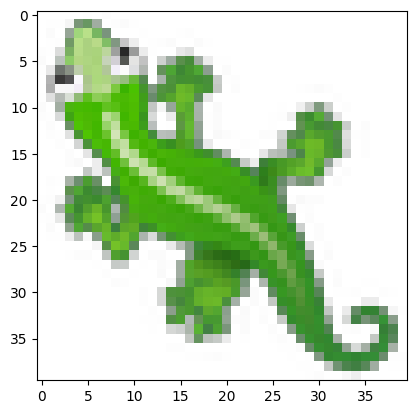

(40, 40, 4)


In [3]:
import cv2
import numpy as np
import imageio
import matplotlib.pyplot as plt

width = 40
height = 40
filename = "/content/emoji_0.png"  # Load the emoji sheet
device = "cuda"

im = (cv2.cvtColor(cv2.resize(cv2.imread(filename, cv2.IMREAD_UNCHANGED), (width,height)), cv2.COLOR_BGRA2RGBA)/255.0).astype(np.float32)
plt.imshow(im)
plt.show()
print(im.shape)



In [5]:
num_channels = 16
seed = np.zeros([1, width, height, num_channels], np.float32)
seed[:,width//2, height//2, 3:] = 1.0

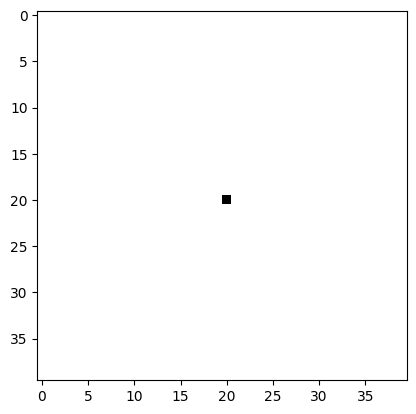

In [6]:
plt.imshow(seed[0,:,:,:4])
plt.show()

In [7]:
class ca_model(nn.Module):
    def __init__(self, checkpoint = None, seq_layers = None, device = 'cuda'):
        '''
        Kind of a modular class for a CA model
        args:
            checkpoint = 'path/to/model.pt'
            seq_layers = nn.Sequential(your, pytorch, layers)
            device = 'cuda' or 'cpu'
        '''
        super(ca_model, self).__init__()

        if seq_layers is not None:
            self.model = seq_layers
        else:
            self.model = nn.Sequential(
                nn.Conv2d(16, 256, kernel_size = 3,padding =1,  bias = True),
                nn.ReLU(),
                nn.Conv2d(256, 16, kernel_size =  1, bias = True),
            )

        '''
        initial condition for "do nothing" behaviour:
            * all biases should be zero
            * the weights of the last layer should be zero
        '''
        for l in range(len(self.model)):
            if isinstance(self.model[l], nn.Conv2d):
                self.model[l].bias.data.fill_(0)
                if l == len(self.model) -1:
                    self.model[l].weight.data.fill_(0)

        if checkpoint is not None:
            self.load_state_dict(torch.load(checkpoint))

        self.to(device= device)

    def normalize_grads(self):
        '''
        gradient normalization for constant step size and to avoid spikes
        '''
        for p in self.parameters():
            p.grad.data = p.grad.data/(p.grad.data.norm()+1e-8)


    def get_alive_mask(self, x):
        '''
        looks for cells that have values over 0.1,
        and allows only their adjacent cells to participate in growth
        '''
        alpha = x[:,3:4,:,:]
        pooled = (F.max_pool2d(alpha, 3,1, padding =1 ) > 0.1).float()
        return pooled

    def train_step(self, seed, target, target_loss_func, iters):
        '''
        a single training step for the model,
        feel free to play around with different loss functions like L1 loss

        the loss is calculated for only the first 4 channels of the output
        '''
        x = seed
        for i in range(iters):
            x =  self.forward(x)

        target_loss  =  target_loss_func(x[:,:4, :,:], target)
        loss = target_loss

        return loss, x

    def forward(self, x):
        '''
        nice little forward function for the model
        1. fetches an alive mask
        2. generates another random mask of 0's and 1's
        3. updates the input
        4. applies alive mask
        '''
        alive_mask = self.get_alive_mask(x)
        mask = torch.clamp(torch.round(torch.rand_like(x[:,:1,:,:])) , 0,1)
        out = x + self.model(x)*mask
        out *= alive_mask

        return out


In [8]:
def to_rgb(img):
    rgb, a = img[:,:,:3], img[:,:,3:4]
    return 1.0-a+rgb

model = ca_model(device = 'cuda')
optimizer = optim.Adam(model.parameters(), lr = 1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size= 600, gamma=0.1)

In [9]:
pool_size = 1024

seed_tensor = torch.tensor(seed).permute(0,-1,1,2).to('cpu')
target = torch.tensor(im.transpose(-1,0,1)).unsqueeze(0).to('cpu')

seed_pool = torch.repeat_interleave(seed_tensor, repeats = pool_size, dim = 0)
losses = []

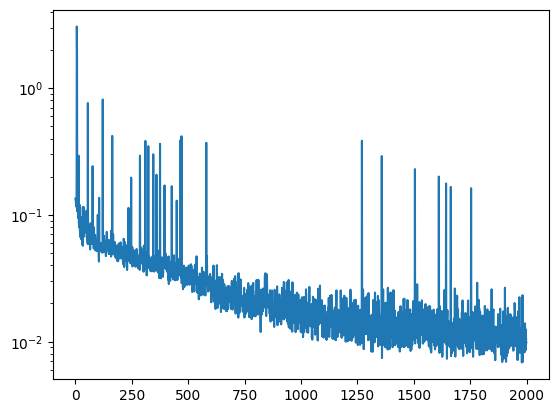

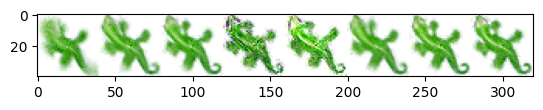

1999 0.009825634770095348


In [10]:

epochs = 2000
sample_size = 8
target_batch = torch.repeat_interleave(target, repeats = sample_size, dim = 0) .to('cuda')

for i in range(epochs):

    scheduler.step()
    batch_idx = np.random.choice(len(seed_pool), sample_size, replace = False)

    seed_batch = seed_pool[batch_idx].to('cuda')

    seed_batch[:1] = seed_tensor.to('cuda')

    loss, out = model.train_step(
        target = target_batch,
        target_loss_func = F.mse_loss,
        iters = 100,
        seed = seed_batch,
        )

    seed_pool[batch_idx] = out.detach().to('cpu')

    loss.backward()

    model.normalize_grads()

    optimizer.step()

    optimizer.zero_grad()

    losses.append(loss.item())

    if i % 20==0 or i  == epochs-1:
        clear_output(True)

        plt.plot(losses)
        plt.yscale('log')
        plt.show()

        stack = []
        for z in range(sample_size):
            stack.append(to_rgb(out[z].permute(-2, -1,0).cpu().detach().numpy()))
        plt.imshow(np.clip(cv2.hconcat(stack), 0,1))
        plt.show()

        print(i, loss.item(), flush = True)


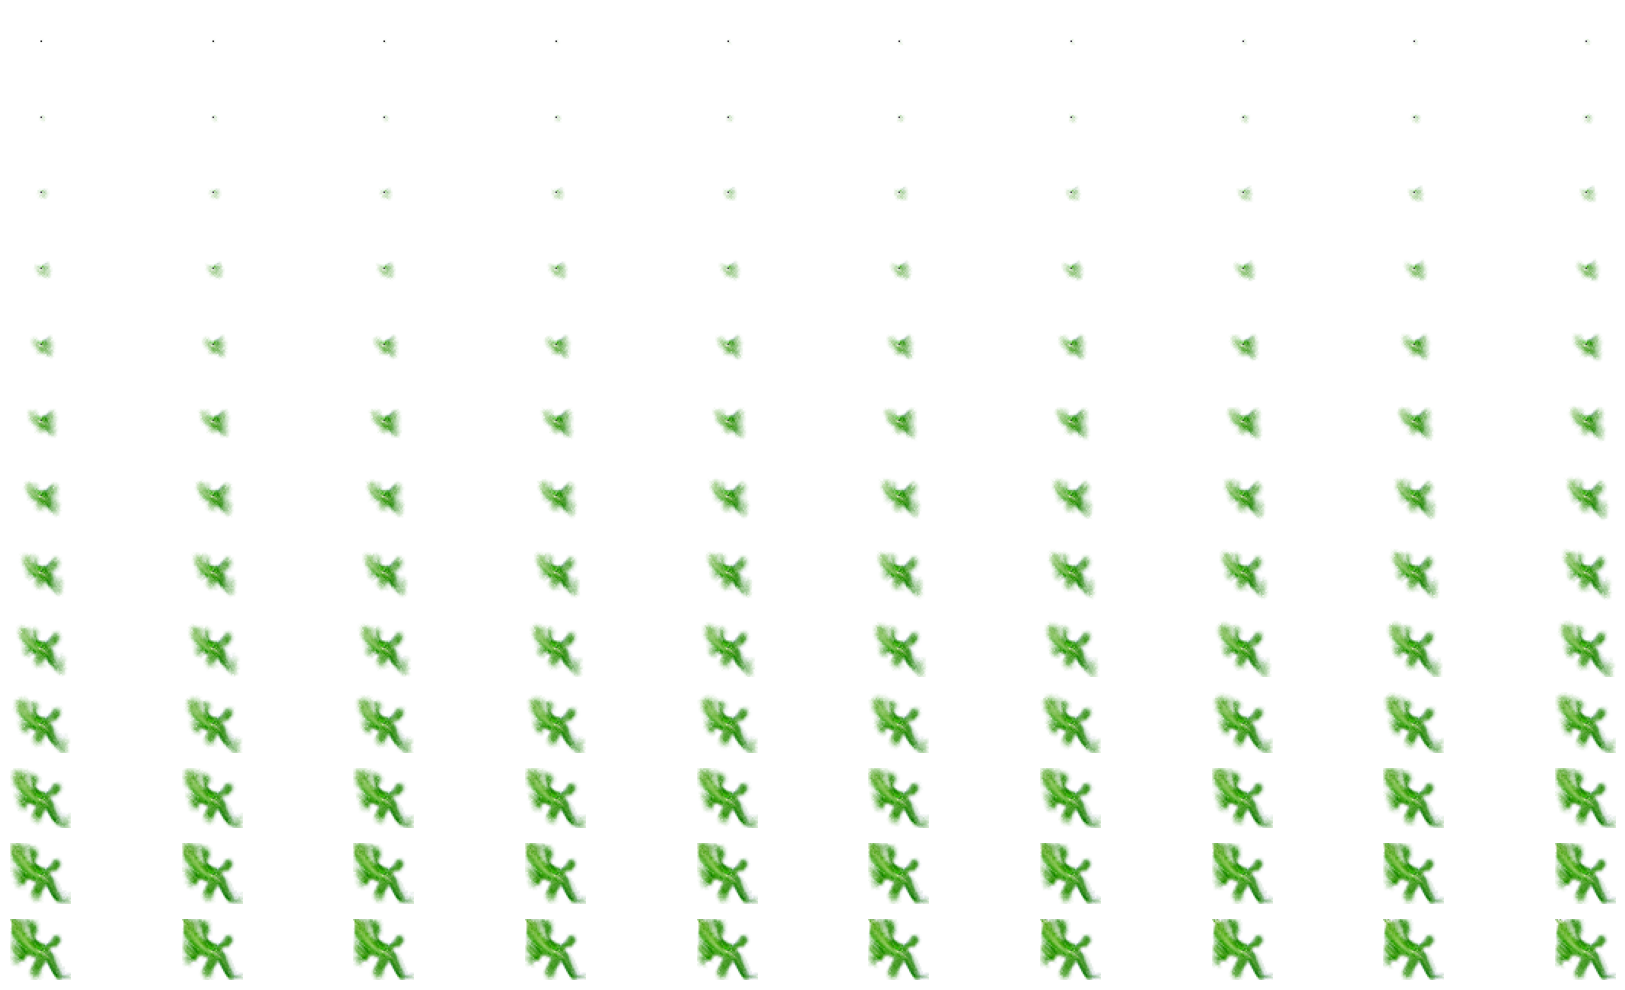

In [12]:
x = torch.tensor(seed).permute(0,-1,1,2).to(device)

outs = []
with torch.no_grad():

    for i in range(130):
        x = model(x)
        out = np.clip(to_rgb(x[0].permute(-2, -1,0).cpu().detach().numpy()), 0,1)
        outs.append(out)

fig, ax = plt.subplots(nrows=13, ncols=10, figsize = (18,10))

for i in range(len(outs)):
    ax.flat[i].imshow(outs[i])
    ax.flat[i].axis("off")

fig.tight_layout()

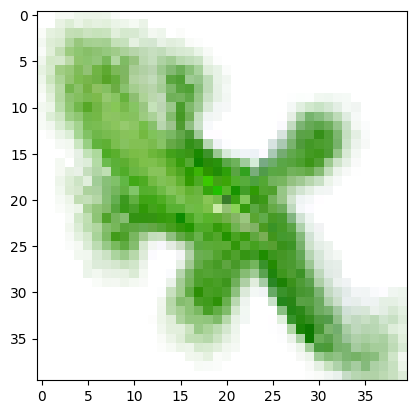

In [17]:
plt.imshow(outs[-30])

In [ ]:
# build gif
import imageio
with imageio.get_writer('lizard.gif', mode='I', duration = 0.001) as writer:
    for out in outs:
        out = cv2.resize(out, (512,512), interpolation = cv2.INTER_NEAREST)
        writer.append_data((out*255).astype(np.uint8))

writer.close()

In [ ]:
torch.save(model.state_dict(), 'nca_lizard.pt')